# Testing.

In [1]:
import sys
sys.path.insert(0,'/p/home/jusers/donayreholtz1/hdfml/MyProjects/PROJECT_haf/users/donayreholtz1/lossy-ml/')

In [2]:
import numpy as np
import time
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
from lossycomp.compress import compress
from lossycomp.decompress import decompress
from lossycomp.plots import single_plot
from lossycomp.encodings import encode_lat, encode_lon

In [3]:
data_or = xr.open_mfdataset('/p/home/jusers/donayreholtz1/hdfml/MyProjects/PROJECT_haf/data/ECMWF/1980/*/temperature.nc', combine='by_coords')
data_or = data_or.sel(time=slice('1980-04-12T00:00:00','1980-04-23T23:00:00'), level = slice(985,1000))
data_or = data_or.transpose('time', 'latitude', 'longitude', 'level')
data_or

<xarray.Dataset>
Dimensions:    (latitude: 721, level: 1, longitude: 1440, time: 288)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 1000
  * time       (time) datetime64[ns] 1980-04-12 ... 1980-04-23T23:00:00
Data variables:
    t          (time, latitude, longitude, level) float32 dask.array<chunksize=(288, 721, 1440, 1), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-07-08 13:03:33 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [4]:
extra = False
soil = False
if extra:
    # In case we use the extra information:
    lat = data_or['t'].coords['latitude'].values
    lon = data_or['t'].coords['longitude'].values

    lat_st = np.stack([encode_lat(x) for x in lat])
    lon_st = np.stack([encode_lon(x) for x in lon])

    lat1, lat2 = np.hsplit(lat_st, 2)
    lon1, lon2 = np.hsplit(lon_st, 2)

    xx, yy = np.meshgrid(lon1, lat1)
    xx2, yy2 = np.meshgrid(lon2, lat2)

    coords_lat = np.concatenate([[xx]] * len(data_or.time), axis=0)
    coords_lon = np.concatenate([[yy]] * len(data_or.time), axis=0)
    coords_lat1 = np.concatenate([[xx2]] * len(data_or.time), axis=0)
    coords_lon1 = np.concatenate([[yy2]] * len(data_or.time), axis=0)

    coords_lat = np.expand_dims(coords_lat, axis=3)
    coords_lon = np.expand_dims(coords_lon, axis=3)

    coords_lat1 = np.expand_dims(coords_lat1, axis=3)
    coords_lon1 = np.expand_dims(coords_lon1, axis=3)

    temp = data_or['t'].values
    data_or =  np.concatenate((temp, coords_lat, coords_lon, coords_lat1, coords_lon1 ),axis = 3)

    data_or.shape
    # 402.84 MB
if soil:
    data_soil = xr.open_mfdataset('/p/home/jusers/donayreholtz1/hdfml/MyProjects/PROJECT_haf/data/ECMWF/1980_single/*/land-sea-mask.nc', combine='by_coords')
    data_soil = data_soil.sel(time=slice('1980-04-12T00:00:00','1980-4-23T23:00:00'),longitude=slice(-180,180), latitude=slice(90,-90))
    data_soil = data_soil.transpose('time', 'latitude', 'longitude')
    data_soil = data_soil['lsm']
    data_soil = np.expand_dims(data_soil.values, axis=3)
    data_or =  np.concatenate((data_or['t'].values, data_soil ),axis = 3)

if not (soil or extra):
    data_or = data_or['t']
    data_or = data_or.values


In [5]:
threshold =0.5
compressed_data = compress(data_or, threshold, extra_channels = False, verbose = True, method='None', mode = 'None', convs = 4, hyp = 'model_basic_3')

{'name': '/FINAL_2/model_basic_3', 'num_convs': 4, 'num_filters': 20, 'kernel_size': 4, 'lr': 0.001, 'res_blocks': 0, 'l2': 5e-05, 'extra': False, 'gaussian': False, 'soil': False}
Load model...
Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 48, 48, 1)]   0         
_________________________________________________________________
Encoder (Functional)         (None, 1, 3, 3, 20)       78160     
_________________________________________________________________
Decoder (Functional)         (None, 16, 48, 48, 1)     103761    
Total params: 181,921
Trainable params: 181,921
Non-trainable params: 0
_________________________________________________________________
None
Standardizing data...
Chunking data...
Compressing data...
compressed.
Start decompressing
decompressed
(8640, 16, 48, 48, 1)
Merging data...
Quantizing data...
Encoding data...
L

error = compressed_data[1]
mask = compressed_data[2]
decompressed = compressed_data[3]
comp_data = compressed_data[4]
decom_error = compressed_data[5]
quan = compressed_data[6]

In [6]:
#Latent space (%): 0.1279761792219548
#Error space (%): 0.8720238207780452
#Postive Error space (%): 0.5171418215153514
#Negative Error mask (%): 0.3548819992626938
#Compression factor: 28.444980214007217
#Latent space compression factor: 204.8
#Done.

#Latent space (%): 0.12905013557089665
#Error + mask space (%): 0.8709498644291034
#Error space (%): 0.14656458599434885
#Error mask (%): 0.7243852784347545
#Compression factor: 28.683659806288752
#Latent space compression factor: 204.8
#Done.

# basic_3
# no mask
#Latent space (%): 0.11956313266086512
#Error space (%): 0.8804368673391348
#Postive Error space (%): 0.5217807313369628
#Negative Error mask (%): 0.35865613600217217
#Compression factor: 26.575084707143084
#Latent space compression factor: 204.8
#Done.


#1
#Compression factor: 86.93010079960554
#Latent space compression factor: 409.6
#Latent space (%): 0.4093427174119003
#Error space + mask (%): 0.5906572825880997
#Error space (%): 0.03228684910783392
#Error mask (%): 0.5583704334802657
#Done

# soil standardize instead of timeee
#Compression factor: 80.20271890039655
#Latent space compression factor: 409.6
#Latent space (%): 0.38127809543684105
#Error space + mask (%): 0.618721904563159
#Error space (%): 0.034940671503572426
#Error mask (%): 0.5837812330595865
#Done.

# model_2
#Compression factor: 83.39476547889888
#Latent space compression factor: 204.8
#Latent space (%): 0.3646146768379935
#Error space + mask (%): 0.6353853231620066
#Error space (%): 0.04327016067909127
#Error mask (%): 0.5921151624829153
#Done.

# soil normal
#Compression factor: 63.21966590824015
#Latent space compression factor: 409.6
#Latent space (%): 0.27516924928897035
#Error space + mask (%): 0.7248307507110296
#Error space (%): 0.051553143925232456
#Error mask (%): 0.6732776067857972
#Done.

# soil residual
#Compression factor: 63.336348915015456
#Latent space compression factor: 409.6
#Latent space (%): 0.24594249569089163
#Error space + mask (%): 0.7540575043091083
#Error space (%): 0.058133365586665466
#Error mask (%): 0.6959241387224429
#Done.

# 400k samples soil
#Compression factor: 79.78155221940405
#Latent space compression factor: 409.6
#Latent space (%): 0.32889973637357
#Error space + mask (%): 0.6711002636264299
#Error space (%): 0.03921477332602954
#Error mask (%): 0.6318854903004004
#Done.

# 100 batch soil
#Compression factor: 80.70439157024288
#Latent space compression factor: 409.6
#Latent space (%): 0.3560989059075647
#Error space + mask (%): 0.6439010940924352
#Error space (%): 0.037131045003587416
#Error mask (%): 0.6067700490888479
#Done.

# -----------------------------------------------------#
#Compression factor: 81.91888906422598
#Latent space compression factor: 204.8
#Latent space (%): 0.3587525574307079
#Error space + mask (%): 0.6412474425692921
#Error space (%): 0.04476747005679161
#Error mask (%): 0.5964799725125005

#Compression factor: 78.32765482752889
#Latent space compression factor: 409.6
#Latent space (%): 0.3232400994233055
#Error space + mask (%): 0.6767599005766944
#Error space (%): 0.0406201184827139
#Error mask (%): 0.6361397820939806

#1.0
# Model res soil
#Compression factor: 56.8944391408194
#Latent space compression factor: 409.6
#Latent space (%): 0.23435867781993042
#Error space + mask (%): 0.7656413221800695
#Error space (%): 0.1283444474000771
#Error mask (%): 0.6372968747799924

# batch 100
#Compression factor: 80.70439157024288
#Latent space compression factor: 409.6
#Latent space (%): 0.3560989059075647
#Error space + mask (%): 0.6439010940924352
#Error space (%): 0.037131045003587416
#Error mask (%): 0.6067700490888479
#Done.

# model_soil_400k
#Compression factor: 69.3174248709744  --> 79
#Latent space compression factor: 409.6
#Latent space (%): 0.3005441216059774
#Error space + mask (%): 0.6994558783940227
#Error space (%): 0.12753008432914126
#Error mask (%): 0.5719257940648813

#basic
#Compression factor: 66.77337730505988
#Latent space compression factor: 204.8
#Latent space (%): 0.2884728320385176
#Error space + mask (%): 0.7115271679614824
#Error space (%): 0.29237243685243514
#Error mask (%): 0.4191547311090473

#0.5
#basic
#Compression factor: 36.54809692692272
#Latent space compression factor: 204.8
#Latent space (%): 0.15789305939345646
#Error space + mask (%): 0.8421069406065436
#Error space (%): 0.4026891315993574
#Error mask (%): 0.43941780900718613

# soil_400k
#Compression factor: 34.613267105662864
#Latent space compression factor: 409.6
#Latent space (%): 0.15007370977506798
#Error space + mask (%): 0.849926290224932
#Error space (%): 0.24025925467175854
#Error mask (%): 0.6096670355531735


#soil normal 
#Compression factor: 31.901468688775406
#Latent space compression factor: 409.6
#Latent space (%): 0.13665352414173124
#Error space + mask (%): 0.8633464758582687
#Error space (%): 0.35535607124132085
#Error mask (%): 0.5079904046169479

# soil_res
#Compression factor: 30.073694416394776
#Latent space compression factor: 409.6
#Latent space (%): 0.12387825232618244
#Error space + mask (%): 0.8761217476738176
#Error space (%): 0.2638846726759404
#Error mask (%): 0.6122370749978772

decompressed_data = decompress(compressed_data[0],extra_channels = False, verbose = False, method='None', mode = 'None', convs = 4, hyp = 'model_basic_3')

mask_d = decompressed_data[1]
error_d = decompressed_data[2]
decom_error_d = decompressed_data[4]
comp_d = decompressed_data[5]
quan_d = decompressed_data[6]
decompressed_d = decompressed_data[7]

In [41]:
error_de = data_or - (decompressed_data[0])
print('Min:', np.min(error_de))
print('Max:', np.max(error_de))

Min: -1.0
Max: 1.0


In [42]:
def psnr(y,x):
    vrange = np.max(y) - np.min(y)
    psnr = 20 * np.log10(vrange - (10 * np.log10(np.mean((y-x)*(y-x)))))
    return psnr


psnr1 = psnr(data_or[:,:,:,0], decompressed_data[:,:,:,0])
print('PSNR', psnr1)

TypeError: tuple indices must be integers or slices, not tuple

(1, 288, 721, 1440, 1)


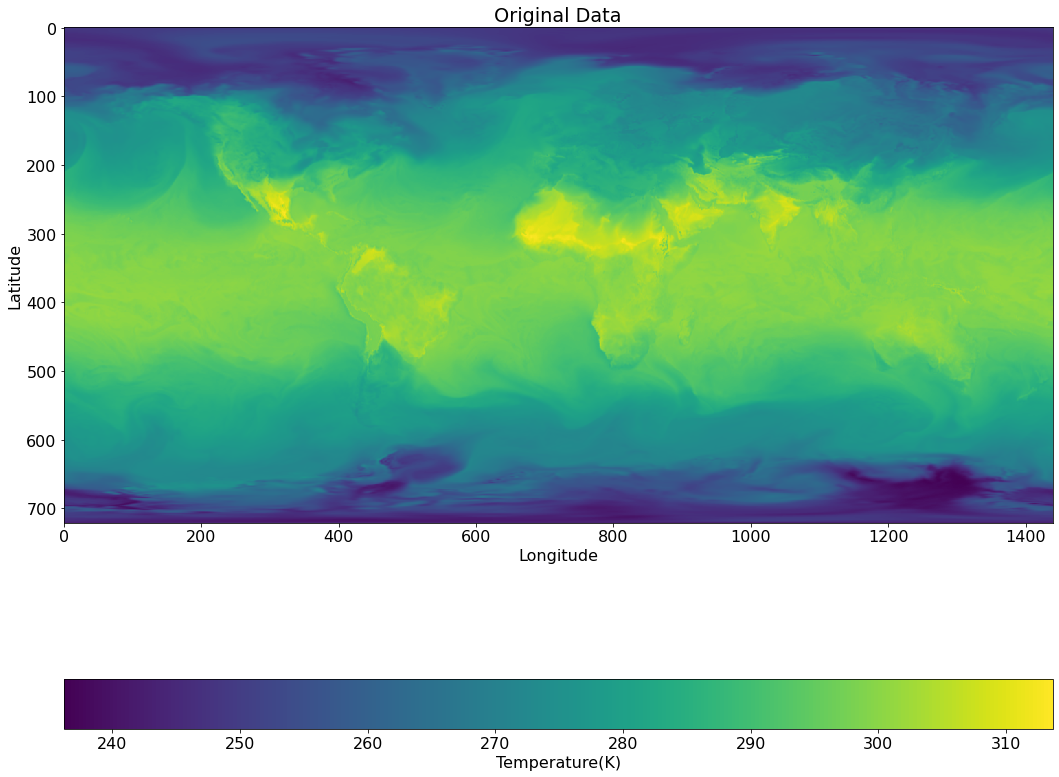

In [15]:
#data_r = np.expand_dims(data_or['lsm'].values[:,:,:], axis=0)
data_r = np.expand_dims(data_or, axis=0)
#data_r = np.expand_dims(data_r, axis=4)
print(data_r.shape)
plt.rcParams.update({'font.size': 16})
single_plot(data_r, 0, "Original Data", "Temperature(K)", data_r[0,0].min(), data_r[0,0].max())

(1, 288, 721, 1440, 1)


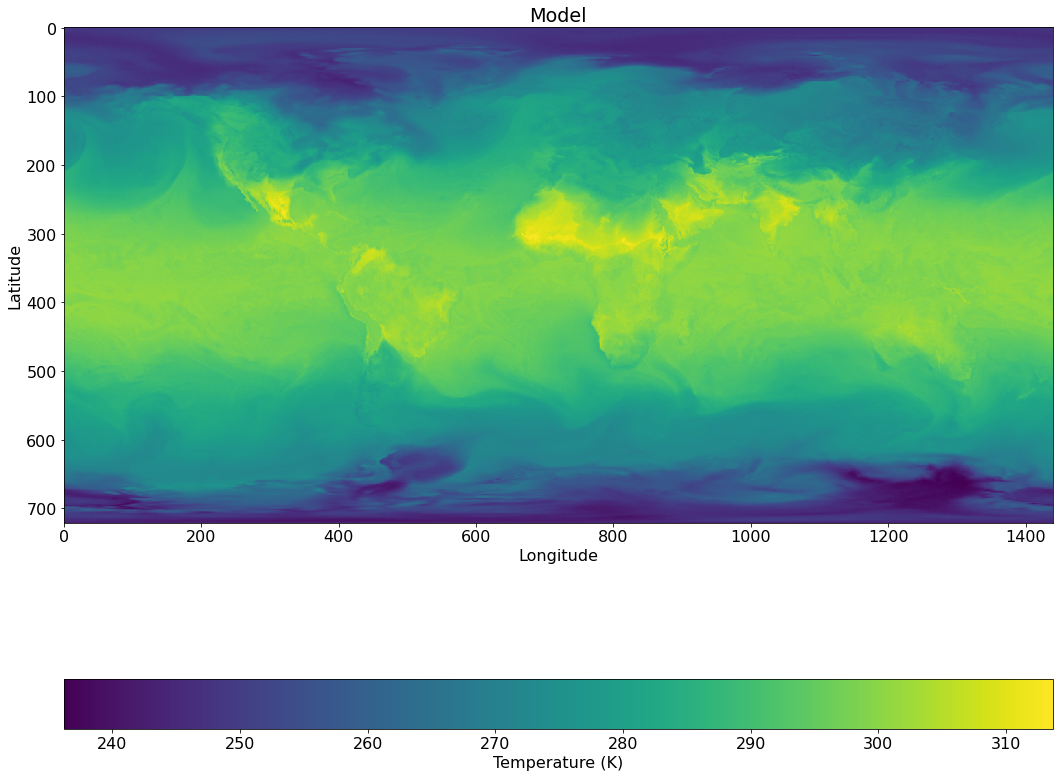

In [16]:
decompressed_data_1 = decompressed_data[0]
decom = np.expand_dims(decompressed_data_1, axis=0)
print(decom.shape)
single_plot(decom, 0, "Model", "Temperature (K)", data_r[0,0].min(), data_r[0,0].max())

(1, 288, 721, 1440, 1)


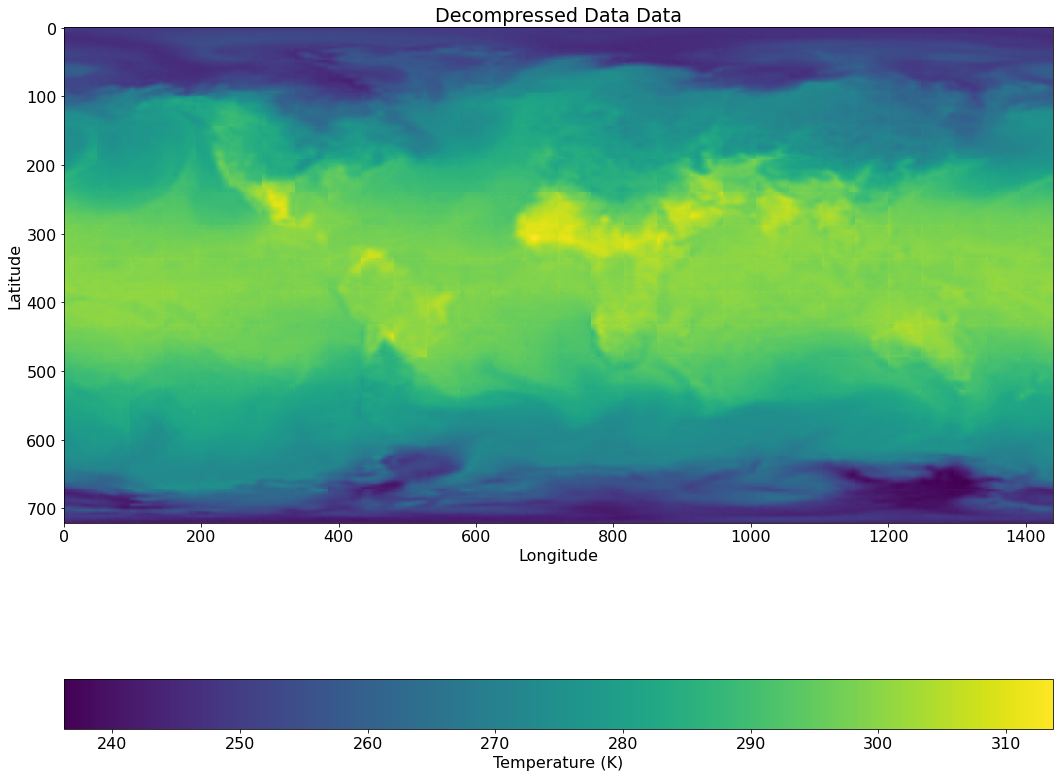

In [17]:
decom_model = decompressed_data[1]
decom1 = np.expand_dims(decom_model, axis=0)
print(decom1.shape)
single_plot(decom1,0, "Decompressed Data Data", "Temperature (K)", data_r[0,0].min(), data_r[0,0].max())

(1, 288, 721, 1440, 1)


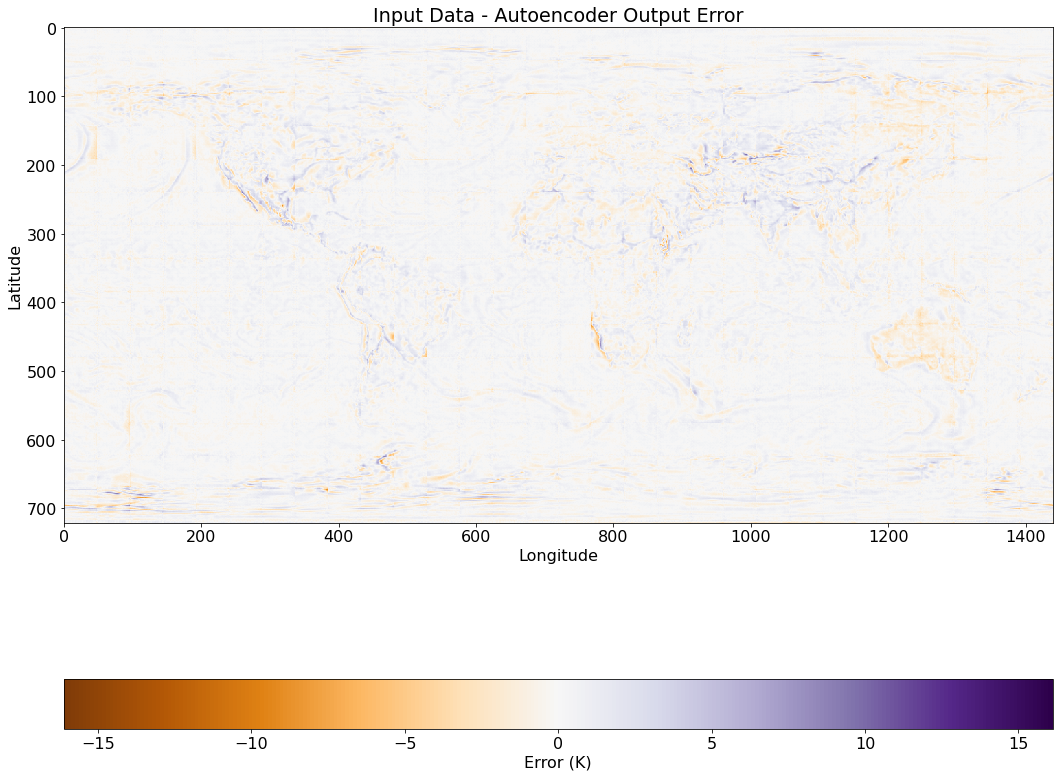

In [18]:
diff = (data_r-decom1)
#diff = np.mean(diff, axis = 1)
#diff = np.expand_dims(diff, axis=0)
print(diff.shape)
# define the colormap
cmap = plt.get_cmap('PuOr')

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
vrange = max((abs(diff.min())), diff.max())

single_plot(diff,0,  "Input Data - Autoencoder Output Error", "Error (K)", -1.0 * vrange, vrange, cmap=cmap)

(1, 288, 721, 1440, 1)


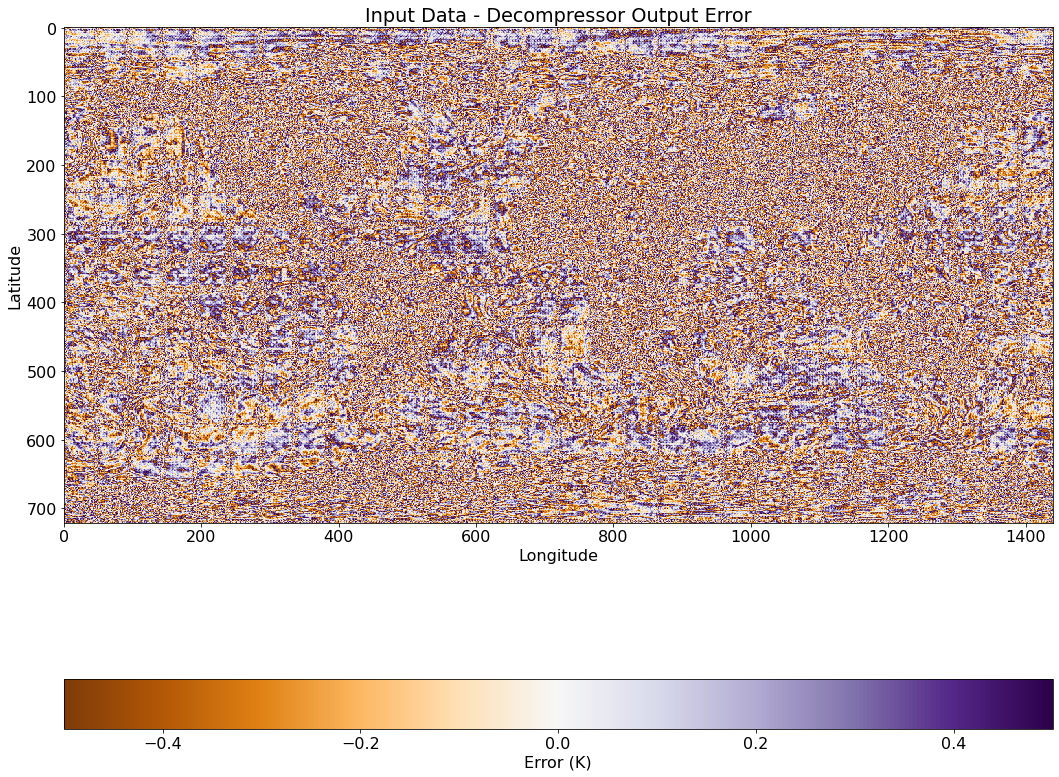

In [19]:
diff = (data_r-decom)
#diff = np.mean(diff, axis = 1)
#diff = np.expand_dims(diff, axis=0)
print(diff.shape)
# define the colormap
cmap = plt.get_cmap('PuOr')

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

single_plot(diff,0,  "Input Data - Decompressor Output Error", "Error (K)", diff.min(), diff.max(), cmap=cmap)


Data Original
Mean: 279.58743
Standard Dev.: 18.20704
Max Val: 317.70856
Min Val: 233.46681

Decompressed
Mean: 279.57755
Standard Dev.: 18.19727
Max Val: 318.57755
Min Val: 232.81511

Error
Mean: 0.010240772
Standard Dev.: 0.3879788
Max error: 1.0
Min error: -1.0



Text(0, 0.5, 'Count')

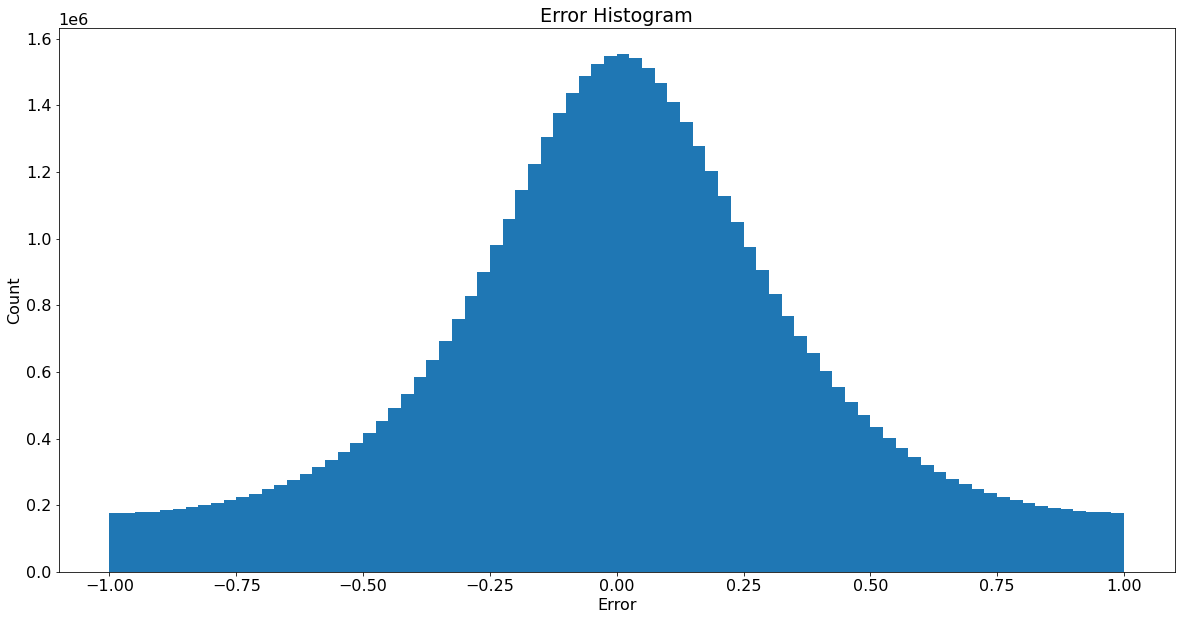

In [19]:
original = data_r
diff = (data_r-decom)

print("")
print("Data Original")
print("=======")
print("Mean:", original.mean())
print("Standard Dev.:", original.std())
print("Max Val:", original.max())
print("Min Val:", original.min())
print("")
print("Decompressed")
print("=======")
print("Mean:", decom.mean())
print("Standard Dev.:", decom.std())
print("Max Val:", decom.max())
print("Min Val:", decom.min())
print("")
print("Error")
print("=======")
print("Mean:", diff.mean())
print("Standard Dev.:", diff.std())
print("Max error:", diff.max())
print("Min error:", diff.min())
print("")


diff2 = data_r-decom
plt.figure(figsize=(20,10))
plt.hist(diff2.flatten(),80)
plt.title('Error Histogram')
plt.xlabel('Error')
plt.ylabel('Count')

In [13]:
import pickle
import numpy as np
with open('../lossycomp/cf_zfp_vs_5_vs_sz_history.pkl', 'rb') as f:
    data = pickle.load(f)

In [9]:
data.keys()
data['sz'].keys()

dict_keys(['cf_0.001', 'cf_0.01', 'cf_0.1', 'cf_0.3', 'cf_0.5', 'cf_0.7', 'cf_1', 'cf_3', 'cf_5'])

In [11]:
cf_1 = []
cf_5 = []
cf_sz = []

cf_1_std = []
cf_5_std = []
cf_sz_std = []

latent_1= []
latent_5=[]
latent_sz=[]

latent_1_std= []
latent_5_std=[]
latent_sz_std=[]

error_1=[]
error_5=[]
error_sz=[]

error_1_std=[]
error_5_std=[]
error_sz_std=[]

vals =  [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1,  3, 5]


for i in [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 3, 5]:
    cf_1.append(np.mean(data['zfp']['cf_' + str(i)]))
    cf_5.append(np.mean(data['channel_5']['cf_' + str(i)]))
    cf_sz.append(np.mean(data['sz']['cf_' + str(i)]))
    
    cf_1_std.append(np.std(data['zfp']['cf_' + str(i)]))
    cf_5_std.append(np.std(data['channel_5']['cf_' + str(i)]))
    cf_sz_std.append(np.std(data['sz']['cf_' + str(i)]))
        
    latent_1.append(np.mean(data['zfp']['latent_' + str(i)]))
    latent_5.append(np.mean(data['channel_5']['latent_' + str(i)]))
    latent_sz.append(np.mean(data['sz']['latent_' + str(i)]))
    
    latent_1_std.append(np.std(data['zfp']['latent_' + str(i)]))
    latent_5_std.append(np.std(data['channel_5']['latent_' + str(i)]))
    latent_sz_std.append(np.std(data['sz']['latent_' + str(i)]))
    
    error_1.append(np.mean(data['zfp']['error_' + str(i)]))
    error_5.append(np.mean(data['channel_5']['error_' + str(i)]))
    error_sz.append(np.mean(data['sz']['error_' + str(i)]))
    
    error_1_std.append(np.std(data['zfp']['error_' + str(i)]))
    error_5_std.append(np.std(data['channel_5']['error_' + str(i)]))
    error_sz_std.append(np.std(data['sz']['error_' + str(i)]))

Text(0, 0.5, 'Compression Factor')

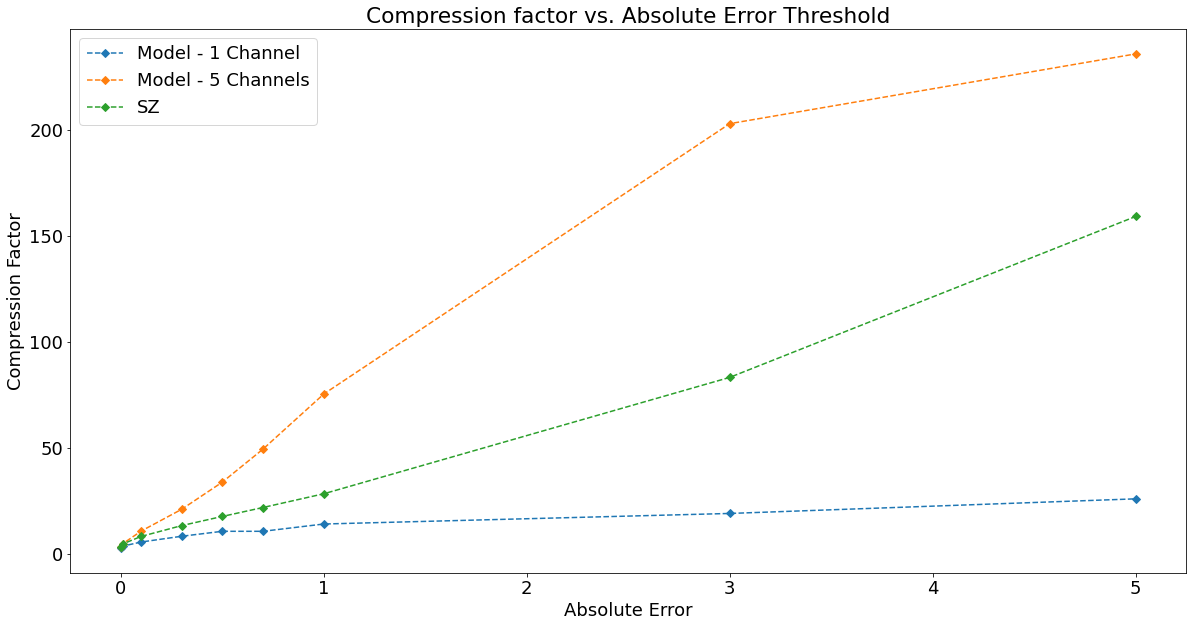

In [12]:
import matplotlib.pyplot as plt
epochs = range(len(cf_1))

plt.figure(figsize=(20,10))
plt.plot(vals, cf_1, '--D', label = "Model - 1 Channel")
plt.plot(vals, cf_5, '--D', label = "Model - 5 Channels")
plt.plot(vals, cf_sz, '--D',  label = "SZ")

plt.legend()
plt.title('Compression factor vs. Absolute Error Threshold')
plt.xlabel('Absolute Error')
plt.ylabel('Compression Factor')

/home/kit/scc/nq1231/.site-packages/lib/jupyter_ml/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


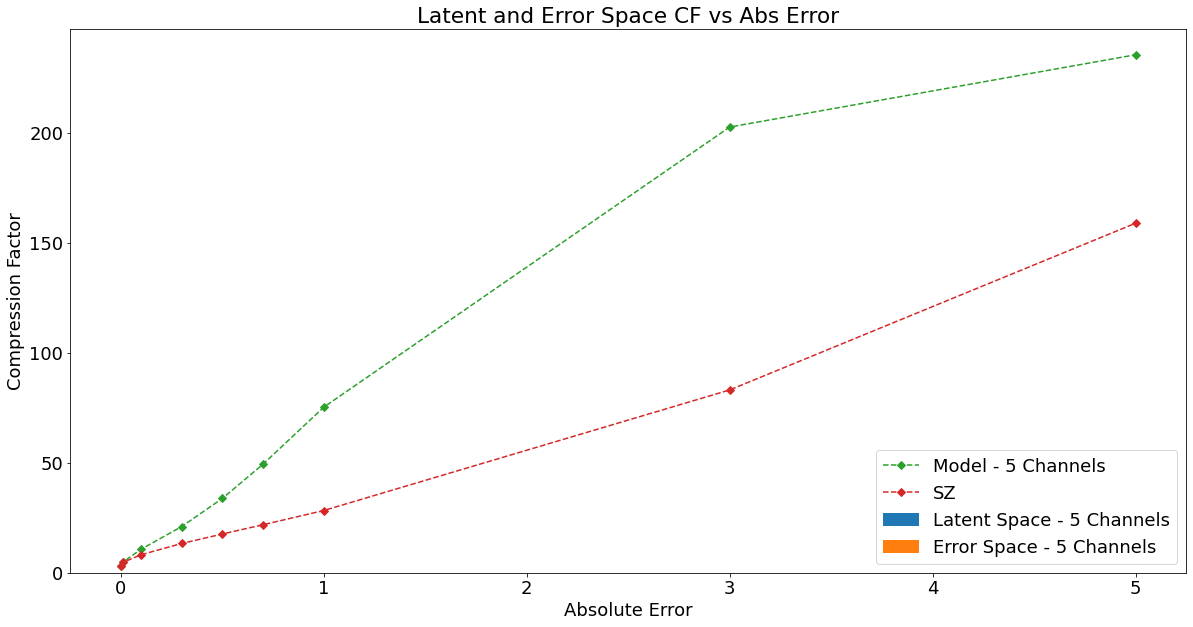

In [13]:

#plt.figure(figsize=(20,10))
width = 0.05# the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(20,10))

vals_2 = np.array(vals) + 0.05

latent_1_x = np.array(latent_1) * np.array(cf_1)
latent_5_x = np.array(latent_5) * np.array(cf_5)

error_1_x = np.array(error_1) * np.array(cf_1)
error_5_x = np.array(error_5) * np.array(cf_5)

latent_1_std_x = np.array(latent_1_std) * np.array(cf_1)
latent_5_std_x = np.array(latent_5_std) * np.array(cf_5)

error_1_std_x = np.array(error_1_std) * np.array(cf_1)
error_5_std_x = np.array(error_5_std) * np.array(cf_5)

#ax.bar(vals,latent_1_x, width, yerr=latent_1_std_x, label='Latent Space - 1 Channel')
#ax.bar(vals, error_1_x, width, yerr= error_1_std_x, bottom=latent_1_x,
#       label='Error Space - 1 Channel')

ax.bar(vals_2,latent_5_x, width, yerr=latent_5_std_x, label='Latent Space - 5 Channels')
ax.bar(vals_2, error_5_x, width, yerr= error_5_std_x, bottom=latent_5_x,
       label='Error Space - 5 Channels')

#ax.plot(vals, cf_1, '--D', label = "Model - 1 Channel")
ax.plot(vals, cf_5, '--D', label = "Model - 5 Channels")
ax.plot(vals, cf_sz, '--D',  label = "SZ")

ax.set_ylabel('Compression Factor')
ax.set_xlabel('Absolute Error')
ax.set_title('Latent and Error Space CF vs Abs Error')
ax.legend()

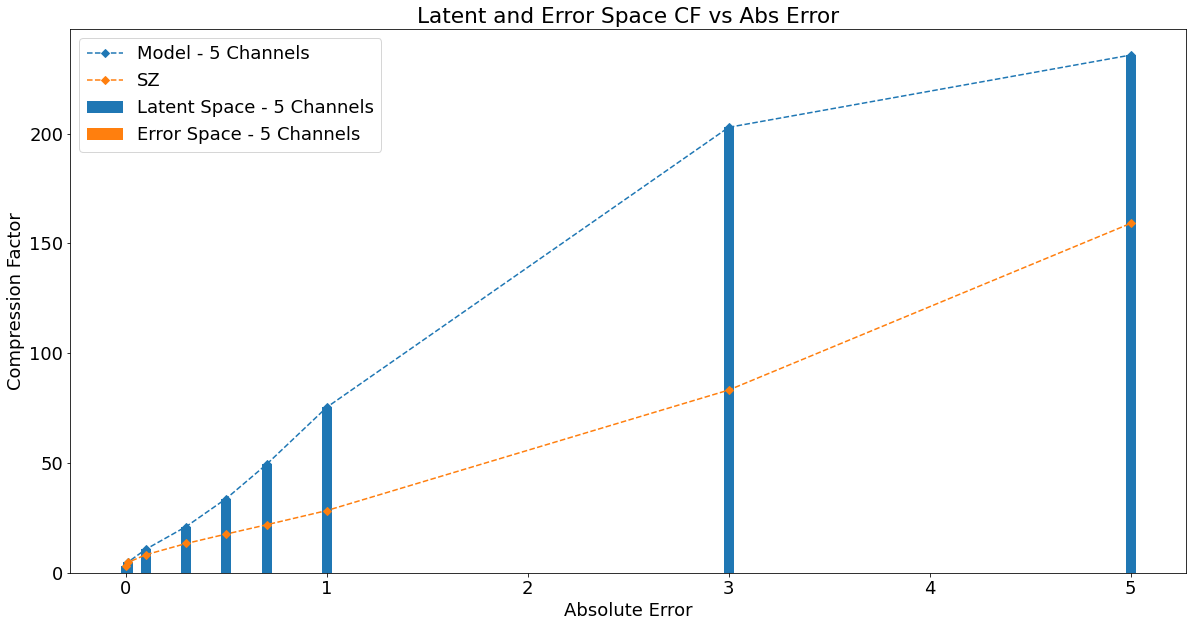

In [14]:

#plt.figure(figsize=(20,10))
width = 0.05# the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(20,10))

vals_2 = np.array(vals) + 0.05

latent_1_x = np.array(latent_1) * np.array(cf_1)
latent_5_x = np.array(latent_5) * np.array(cf_5)

error_1_x = np.array(error_1) * np.array(cf_1)
error_5_x = np.array(error_5) * np.array(cf_5)

latent_1_std_x = np.array(latent_1_std) * np.array(cf_1)
latent_5_std_x = np.array(latent_5_std) * np.array(cf_5)

error_1_std_x = np.array(error_1_std) * np.array(cf_1)
error_5_std_x = np.array(error_5_std) * np.array(cf_5)

#ax.bar(vals,latent_1_x, width, yerr=latent_1_std_x, label='Latent Space - 1 Channel')
#ax.bar(vals, error_1_x, width, yerr= error_1_std_x, bottom=latent_1_x,
#       label='Error Space - 1 Channel')

#ax.bar(vals_2,latent_5_x, width, yerr=latent_5_std_x, label='Latent Space - 5 Channels')
#ax.bar(vals_2, error_5_x, width, yerr= error_5_std_x, bottom=latent_5_x,
#       label='Error Space - 5 Channels')

#ax.plot(vals, cf_1, '--D', label = "Model - 1 Channel")
ax.plot(vals, cf_5, '--D', label = "Model - 5 Channels")
ax.plot(vals, cf_sz, '--D',  label = "SZ")

ax.bar(vals, cf_5, width, yerr=latent_5_std_x, label='Latent Space - 5 Channels')
ax.bar(vals, cf_sz, width, yerr= error_5_std_x, bottom=latent_5_x,
       label='Error Space - 5 Channels')



ax.set_ylabel('Compression Factor')
ax.set_xlabel('Absolute Error')
ax.set_title('Latent and Error Space CF vs Abs Error')
ax.legend()

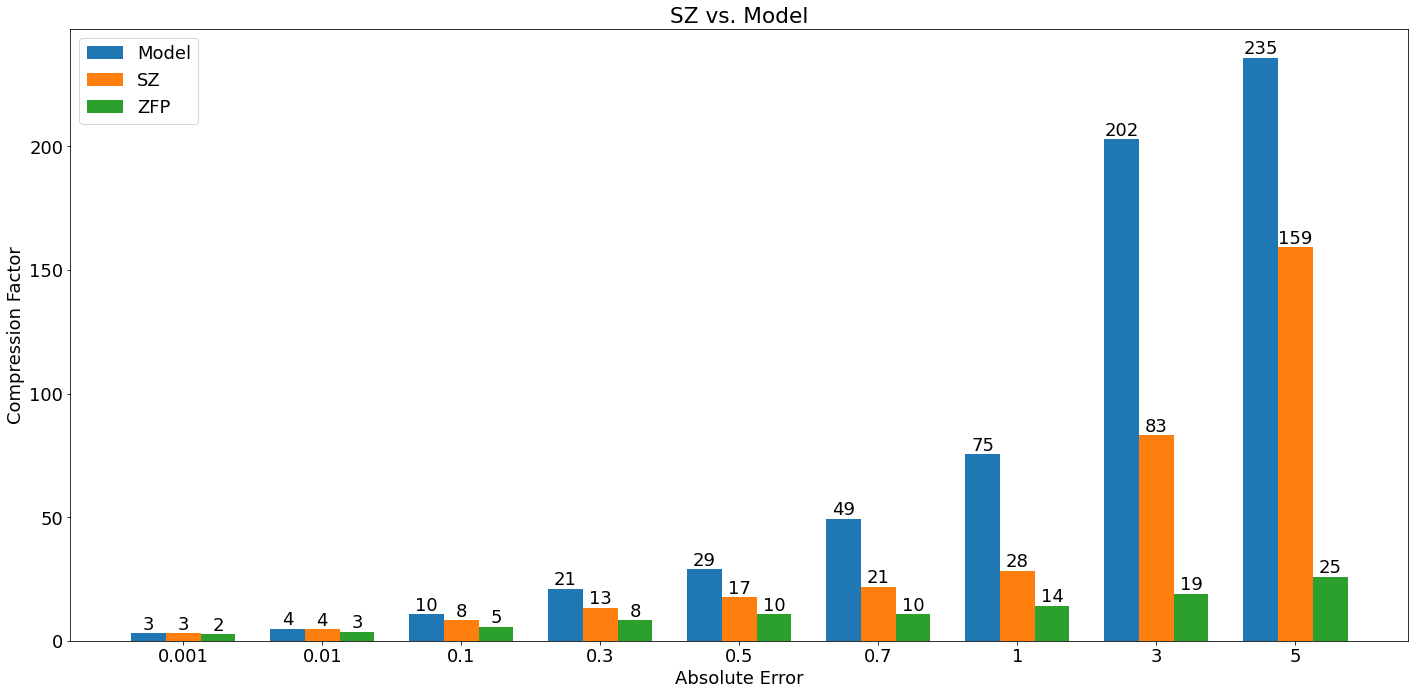

<Figure size 1440x720 with 0 Axes>

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 18})
labels = ['0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1', '3', '5']
cf_5[4]=29
men_means = cf_5
women_means =cf_sz
women_means_1 =cf_1

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize = (20,10))
rects1 = ax.bar(x - width, men_means, width, label='Model')
rects2 = ax.bar(x , women_means, width, label='SZ')
rects3 = ax.bar(x + width, women_means_1, width, label='ZFP')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Compression Factor')
ax.set_xlabel('Absolute Error')
ax.set_title('SZ vs. Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.00*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.figure(figsize=(20,10))
plt.show()

In [14]:
vals

[0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 3, 5]

In [17]:
cf_sz

[3.1324225117394304,
 4.725736960798262,
 8.239808880514522,
 13.349114160332292,
 17.659935454882376,
 21.867436189191366,
 28.354627739115028,
 83.238168992133,
 159.12871713293728]

In [18]:
cf_5

[3.089510044457301,
 4.8374298338995185,
 10.751983396612875,
 21.050319914681236,
 29,
 49.376163425361135,
 75.3991490401777,
 202.9042005882004,
 235.80728975523692]

In [19]:
cf_1

[2.731679345727254,
 3.6728615857497067,
 5.596247844767189,
 8.314779502363336,
 10.648533944291238,
 10.648533944291238,
 14.086528676561173,
 19.06838536586952,
 25.95705536191974]

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
with open('../results/FINAL/CF_model_sz_zfp_1.pkl', 'rb') as f:
    data = pickle.load(f)

    
    
plt.rcParams.update({'font.size': 18})

labels = ['0.0001', '0.001', '0.01', '0.1', '0.3', '0.5', '0.7', '1']



men_means = cf_5
women_means =cf_sz
women_means_1 =cf_1

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize = (20,10))
rects1 = ax.bar(x - width, men_means, width, label='Model')
rects2 = ax.bar(x , women_means, width, label='SZ')
rects3 = ax.bar(x + width, women_means_1, width, label='ZFP')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Compression Factor')
ax.set_xlabel('Absolute Error')
ax.set_title('SZ vs. Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left')

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.00*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.figure(figsize=(20,10))
plt.show()



In [4]:
import numpy as np
a = np.array([1,2,3,4,5])
a[2:5]

array([3, 4, 5])

In [15]:
import pickle
import numpy as np
with open('../results/FINAL/OPTIM/1/model-history.pkl', 'rb') as f:
    data = pickle.load(f)

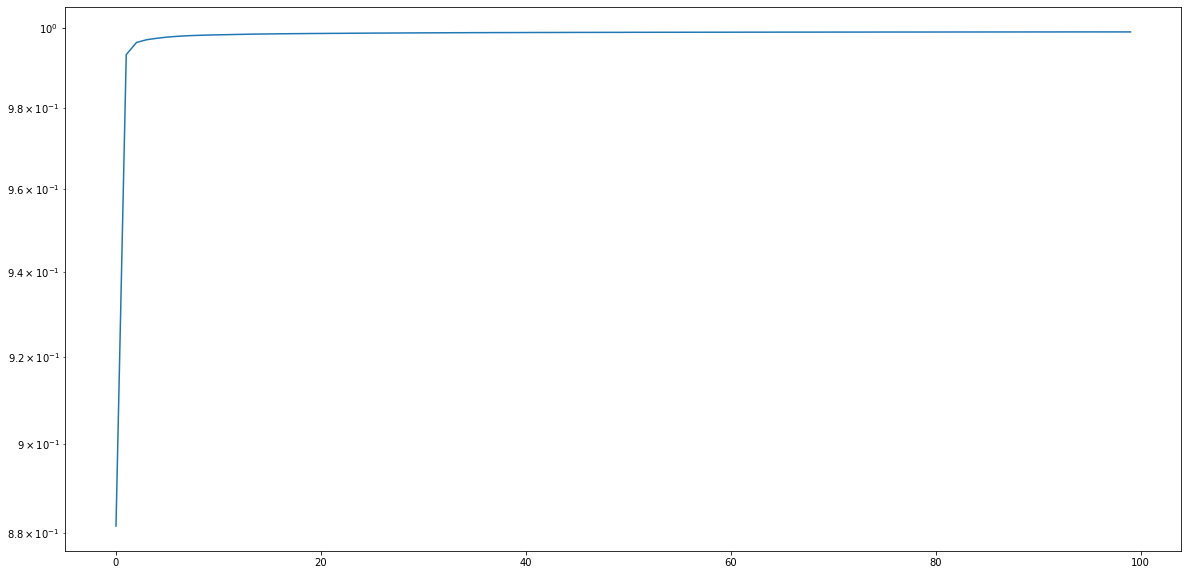

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle


x = range(len(data['model']['psnr']))
plt.figure(figsize=(20,10))
plt.plot(x, data['model']['correlation_5'])
plt.yscale("log")

plt.show()


In [6]:
import pickle
import numpy as np
with open('../../results/FINAL_2/model_3/model-history.pkl', 'rb') as f:
    data = pickle.load(f)

In [7]:
data

{'parameters': {'name': '/FINAL_2/model_3',
  'num_convs': 4,
  'num_filters': 23,
  'kernel_size': 4,
  'lr': 0.00038171359764230917,
  'res_blocks': 1,
  'l2': 9.735422084893119e-05,
  'extra': False,
  'gaussian': False},
 'model': defaultdict(list,
             {'loss': [0.41935965418815613,
               0.07245313376188278,
               0.061878398060798645,
               0.05578503757715225,
               0.04756917804479599,
               0.04453248158097267,
               0.038613203912973404,
               0.036728497594594955,
               0.034122172743082047,
               0.031318627297878265,
               0.03013605996966362,
               0.027887780219316483,
               0.02690543793141842,
               0.025267109274864197,
               0.024020129814743996,
               0.02304922416806221,
               0.02285999059677124,
               0.023224856704473495,
               0.020907552912831306,
               0.02075226604938507,
         